# Pairtools phase walkthrough

Welcome to the pairtools phase walkthrough! This notebook will guide you through the process of resolving contacts between homologous chromosomes using haplotype-resolved Hi-C analysis.

## What is haplotype-resolved Hi-C?

Haplotype-resolved Hi-C distinguishes interactions within individual chromosomes (cis-homolog contacts) from those between homologous chromosomes (trans-homolog contacts). This separation is possible because homologous chromosomes carry variations (e.g. single nucleotide variants, or, SNVs) that can be used to tell them apart.

The experimental challenge of haplotype-resolved Hi-C is to increase the number of SNVs that are essential to distinguish reads from different chromosomes. This can be done by mating highly diverged homozygous strains and studying their F1 progeny. 

Several studies have successfully leveraged haplotype-resolved Hi-C for novel insights:
1. Erceg et al. (2019) explored chromosome pairing in Drosophila embryos [1].
2. Collombet et al. (2020) studied chromosomal organization during early mammalian embryogenesis [2].
3. Tan et al. 2018 uses available heterozygous positions to infer the 3D structures of single chromosomes by single-cell variant of the protocol Dip-C [3]
4. Duan et al. use dikaryonic nuclei of fungi with 0.7% heterozygosity [4]

Several approaches have been developed to process Hi-C data from haplotype-resolved experiments. In `pairtools`, we implement the approach that was used in Erceg et al. Here is its brief outline:

1. Create the haplotype-resolved genome. First, we will create a "concatenated" reference genome that contains sequences of both homologs of each chromosome.  

    - Incorporate known SNVs (usually in .vcf format) into the reference genome using [bcftools](https://samtools.github.io/bcftools/bcftools.html) to create FASTA files with the sequences of both homologs.
    - Add suffixes to the name of each homolog that identify the type (`_hap1` or `_hap2`).

2. Map the Hi-C data to the concatenated reference and parse resulting alignment into Hi-C pairs. Compared to the standard Hi-C pipeline, this step would contain a couple of modifications:
    - Make the aligner report two suboptimal alignments (aka the second and the third hit).
    - Parse allowing multimappers (mapq 0). 
    
    Note that, upon mapping to the homolog-resolved genome, Hi-C reads will report the identity of their homologue as the suffix of the chromosome name.
    
3. Phase the resulting pairs based on the reported suboptimal alignments. 

    By checking the scores of two suboptimal alignments, we will distinguish the true multi-mappers from unresolved pairs (i.e. cases when the read aligns to the location with no distinguishing SNV). Phasing will remove the haplotype suffixes from chromosome names and add extra fields to the .pairs file with:

    - '.' (non-resolved)
    - '0' (first haplotype)    
    - '1' (second haplotype)
    
    Phasing schema: 
    
    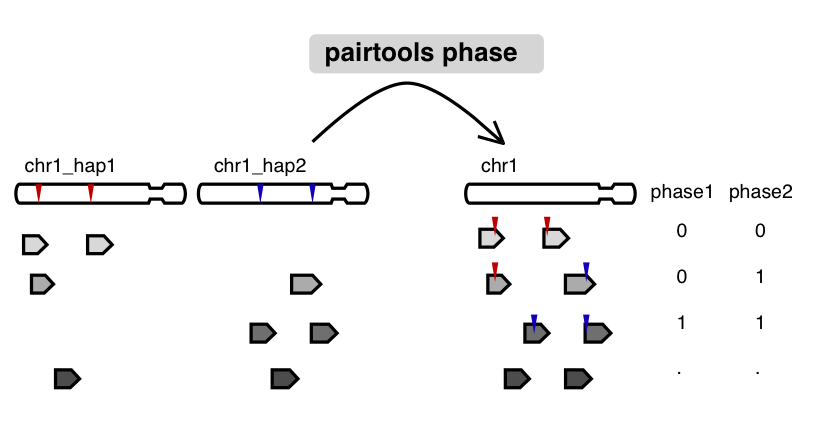


4. Post-procesing. Sort and [dedup](#pairtools-dedup) Hi-C pairs and calculate [stats](#Stats), similarly to the standard Hi-C pipeline. 

[1] Erceg, J., AlHaj Abed, J., Goloborodko, A., Lajoie, B. R., Fudenberg, G., Abdennur, N., Imakaev, M., McCole, R. B., Nguyen, S. C., Saylor, W., Joyce, E. F., Senaratne, T. N., Hannan, M. A., Nir, G., Dekker, J., Mirny, L. A., & Wu, C. T. (2019). The genome-wide multi-layered architecture of chromosome pairing in early Drosophila embryos. Nature communications, 10(1), 4486. https://doi.org/10.1038/s41467-019-12211-8

[2] Collombet, S., Ranisavljevic, N., Nagano, T., Varnai, C., Shisode, T., Leung, W., Piolot, T., Galupa, R., Borensztein, M., Servant, N., Fraser, P., Ancelin, K., & Heard, E. (2020). Parental-to-embryo switch of chromosome organization in early embryogenesis. Nature, 580(7801), 142–146. https://doi.org/10.1038/s41586-020-2125-z

[3] Tan, L., Xing, D., Chang, C. H., Li, H., & Xie, X. S. (2018). Three-dimensional genome structures of single diploid human cells. Science (New York, N.Y.), 361(6405), 924–928. https://doi.org/10.1126/science.aat5641

[4] Duan, H., Jones, A. W., Hewitt, T., Mackenzie, A., Hu, Y., Sharp, A., Lewis, D., Mago, R., Upadhyaya, N. M., Rathjen, J. P., Stone, E. A., Schwessinger, B., Figueroa, M., Dodds, P. N., Periyannan, S., & Sperschneider, J. (2022). Physical separation of haplotypes in dikaryons allows benchmarking of phasing accuracy in Nanopore and HiFi assemblies with Hi-C data. Genome biology, 23(1), 84. https://doi.org/10.1186/s13059-022-02658-2


We will test this pipeline on a sample from Collombet et al. 2019 [2], which is a great example of single-cell Hi-C obtained on mice hybrids of highly heterozygous parents. For the sake of brevity, we will focus on just one cell from the dataset, GSM3691125_2CSE_70. 

Note that, because this is a single-cell sample, the properties of this dataset may differ from what you may obtain on bulk data. 

## Create the homolog-resolved genome

To phase input reads, we need to map the data to the concatenated genome with two haplotypes. 
Below, we will generate such genome in several steps. You will need a reference genome, and one or two lists of mutations to instroduce to the reference.

#### Download reference genome

In [5]:
! wget https://ftp.ensembl.org/pub/release-68/fasta/mus_musculus/dna/Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz

--2024-03-18 13:18:25--  https://ftp.ensembl.org/pub/release-68/fasta/mus_musculus/dna/Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 861993605 (822M) [application/x-gzip]
Saving to: ‘Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz’

Mus_musculus.GRCm38 100%[===================>] 822.06M  2.43MB/s    in 5m 35s  

2024-03-18 13:24:01 (2.45 MB/s) - ‘Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz’ saved [861993605/861993605]



The genome must be indexed for subsequent steps. However, indexing requires the genome to be compressed with bgzip.

In [13]:
%%bash
zcat Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz | bgzip -c > Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.bgz
samtools faidx Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.bgz
rm Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.gz

#### Download .vcf file with variants

In [4]:
! wget https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz

--2024-03-18 13:18:14--  https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 785849127 (749M) [application/x-gzip]
Saving to: ‘CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz.2’

 CAST_EiJ.mgp.v5.sn   0%[                    ]   4.82M  2.42MB/s               ^C


#### Index the variants

In [6]:
! bcftools index CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz

#### Introduce the variants into the genome

In [16]:
%%bash
bcftools consensus --fasta-ref Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.bgz \
  --haplotype 1 CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz | sed -E 's/(>[^[:space:]]+).*/\1_hap1/g' | bgzip -c > GRCm38_EiJ_snpsonly_hap1.fa.gz

bcftools consensus --fasta-ref Mus_musculus.GRCm38.68.dna_sm.toplevel.fa.bgz \
  --haplotype 2 CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz | sed -E 's/(>[^[:space:]]+).*/\1_hap2/g' | bgzip -c > GRCm38_EiJ_snpsonly_hap2.fa.gz


Note that some of these inserted variants may change the total number of nucleotides. This would introduce differences between the coordinate systems of two homologs and complicate downstream analyses. Thus, to make your analyses simpler.you may want insert only single-nuleotide variants and exclude 
by using `--include` parameter of `bcftools consensus` (e.g. `--include '(STRLEN(REF)=1) & (STRLEN(ALT[0])=1)'`).
This will make sure that the genomic coorditates correspond between the haplotypes. 
Correspondence of coordinates is not a requirement, but might be important for downstream analysis. 

#### Create the bwa index of homolog-resolved genome

Concatenate the genomes of two homologs and index them together. 

In [17]:
%%bash
cat GRCm38_EiJ_snpsonly_hap1.fa.gz GRCm38_EiJ_snpsonly_hap2.fa.gz > GRCm38_EiJ_snpsonly.fa.gz
bwa index GRCm38_EiJ_snpsonly.fa.gz

[bwa_index] Pack FASTA... 62.34 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=10923487096, availableWord=780616804
[BWTIncConstructFromPacked] 10 iterations done. 99999992 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 199999992 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 299999992 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 399999992 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 499999992 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 599999992 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 699999992 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 799999992 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 899999992 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 999999992 characters processed.
[BWTIncConstructFromPacked] 110 iterations done.

Generate chromosome sizes file: 

In [18]:
%%bash
faidx GRCm38_EiJ_snpsonly.fa.gz -i chromsizes > GRCm38_EiJ_snpsonly.chromsizes

## Download data

Uncomment the `--minSpotId` and `--maxSpotId` if you want to run the small test instead of full run.

In [2]:
! fastq-dump SRR8811373 --gzip --split-spot --split-3 # --minSpotId 0 --maxSpotId 1000000

In [3]:
! ls SRR8811373*.fastq.gz

SRR8811373_1.fastq.gz  SRR8811373_2.fastq.gz


## Map data with bwa mem to diploid genome

In homolog-resolved Hi-C experiments, reads are first aligned against the reference genome and then parsed with pairtools, similar to the standard pairtools-based Hi-C pipeline. However, an additional challenge arises in distinguishing between un-phaseable reads (reads that map equally well to two homologous locations on two homologous chromosomes) and multimappers (reads that map to repeats in the genome).

To differentiate between these cases, we can examine the top three candidate alignments for each read:
- If the top two alignments map to two homologs of the same chromosome with identical scores, and the third-best alignment has a lower score, the read is considered un-phaseable.
- Conversely, if the third-best alignment has the same score as the first two, the read is classified as a multimapper.

bwa mem provides information on the top three alignments, but the exact usage depends on the version:

1. Regular bwa binary (using XA alignment tag):

The latest official bwa release (0.7.17-r1188, as of March 2024) includes the XA tag, which lists alternative (secondary) alignments, their CIGARs, and the number of mismatches relative to the reference. pairtools parse can parse this tag along with other alignment characteristics (AS, XS, and NM tags) to infer the scores of the top three alignments. In this case, no extra mapping flags are required besides the standard Hi-C flags -SP:

```bash
bwa mem -SP -t 5 mm10_EiJ_snpsonly.fa.gz est.1.fastq.gz test.2.fastq.gz | samtools view -@ 8 -b > mapped.XA.bam
```

2. Cutting-edge bwa version from GitHub (using XB alignment tag):

The latest unreleased version of bwa, available on GitHub, can directly report the scores of all secondary alignments using the XB tag, providing more precise results. To use this option, download bwa's source code, compile it manually, and align reads with an additional -u flag:

```bash
./bwa/bwa mem -SPu -t 5 mm10_EiJ_snpsonly.fa.gz test.1.fastq.gz test.2.fastq.gz | samtools view -@ 8 -b > mapped.XB.bam
```

In this tutorial, we will use the first, simpler option.

Note: [bwa-mem2](https://github.com/bwa-mem2/bwa-mem2) produces [very similar results to bwa mem](https://github.com/open2c/pairtools/discussions/118) while being [x2-3 times faster](https://github.com/bwa-mem2/bwa-mem2#performance). pairtools are compatible with bwa-mem2, and its use is highly recommended for improved performance.

In [4]:
%%bash
bwa mem -SP -t 5 GRCm38_EiJ_snpsonly.fa.gz SRR8811373_1.fastq.gz SRR8811373_2.fastq.gz \
  | samtools view -@ 8 -b > mapped.XA.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 331126 sequences (50000026 bp)...
[M::process] read 127590 sequences (19265939 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 238, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (70, 98, 141)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 283)
[M::mem_pestat] mean and std.dev: (109.44, 53.37)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 354)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 331126 reads in 276.310 CPU sec, 55.358 real sec
[W::bseq_read] the 1st file has fewer sequences.
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 98, 0, 0)
[M::mem_pestat] skip orientation FF as t

## pairtools parse

In order to be phased, parsed Hi-C pairs need to (a) be parsed without mapq filtering and (b) contain a few additional tags (XA,NM,AS,XS). 
The former modification (a) is needed, because, the default `--min-mapq` value of 1 removes all multiply mapped sequences. This also removes all un-phaseable reads, as they map equally well to both homologs and thus have mapq of 0. Since we would like to keep un-phaseable reads, we need to set --min-mapq 0.

In [5]:
%%bash
pairtools parse --min-mapq 0 --add-columns XA,NM,AS,XS --drop-sam --walks-policy all \
  -c GRCm38_EiJ_snpsonly.chromsizes mapped.XA.bam -o unphased.XA.pairs.gz

[E::idx_find_and_load] Could not retrieve index file for 'mapped.XA.bam'


count the number of pairs in the output file

In [7]:
!zcat unphased.XA.pairs.gz | grep -v ^\# | wc -l

253813


## pairtools phase

Phasing will remove the tags "\_hap1" and "\_hap2" from chromosome names and add a separate field for the phase:

In [8]:
%%bash
pairtools phase --phase-suffixes _hap1 _hap2 --tag-mode XA --clean-output unphased.XA.pairs.gz -o phased.XA.pairs.gz

## pairtools dedup

Sort prior to dedup: 

In [9]:
%%bash
pairtools sort phased.XA.pairs.gz --nproc 10 -o phased.sorted.XA.pairs.gz

Deduplication now should take additional columns with phases into account: 

In [10]:
%%bash
pairtools dedup --mark-dups --extra-col-pair phase1 phase2 \
  --output-dups - --output-unmapped - --output-stats phased.XA.dedup.stats \
  -o phased.sorted.XA.nodup.pairs.gz phased.sorted.XA.pairs.gz

In [17]:
!cat phased.XA.dedup.stats | head -35

total	232761
total_unmapped	29132
total_single_sided_mapped	44444
total_mapped	159185
total_dups	5219
total_nodups	153966
cis	17712
trans	136254
pair_types/MM	21281
pair_types/NM	7241
pair_types/NN	610
pair_types/NU	19507
pair_types/MU	22736
pair_types/UU	153966
pair_types/UM	2201
pair_types/DD	5219
cis_1kb+	9470
cis_2kb+	9225
cis_4kb+	8839
cis_10kb+	8161
cis_20kb+	7590
cis_40kb+	7162
summary/frac_cis	0.11503838509800865
summary/frac_cis_1kb+	0.06150708598002156
summary/frac_cis_2kb+	0.05991582557187951
summary/frac_cis_4kb+	0.05740877856150059
summary/frac_cis_10kb+	0.053005208942234
summary/frac_cis_20kb+	0.049296597950196794
summary/frac_cis_40kb+	0.046516763441279245
summary/frac_dups	0.032785752426422086
summary/complexity_naive	2374298.3333298806
chrom_freq/1/1	4333
chrom_freq/10/10	7537
chrom_freq/1/6	173
chrom_freq/1/7	121


Dedup might generate warning that phase columns now contain mixed data types ('.' alongside with 0 and 1). This warning is inherited from reading by reading the pairs file by pandas.

## Stats

First, filter different types of reads:

In [30]:
%%bash
pairtools select '(phase1=="0") and (phase2=="0")' phased.sorted.XA.nodup.pairs.gz -o phased.XA.phase0.pairs.gz
pairtools select '(phase1=="1") and (phase2=="1")' phased.sorted.XA.nodup.pairs.gz -o phased.XA.phase1.pairs.gz
pairtools select '(phase1==".") or (phase2==".")' phased.sorted.XA.nodup.pairs.gz -o phased.XA.unphased.pairs.gz
pairtools select '(phase1!=phase2) and (phase1!=".") and (phase2!=".") and (phase1!="!") and (phase2!="!")' phased.sorted.XA.nodup.pairs.gz \
  -o phased.XA.trans-phase.pairs.gz

Calculate stats for these different types:

In [31]:
%%bash
pairtools stats phased.XA.phase0.pairs.gz -o phased.XA.phase0.stats
pairtools stats phased.XA.phase1.pairs.gz -o phased.XA.phase1.stats
pairtools stats phased.XA.unphased.pairs.gz -o phased.XA.unphased.stats
pairtools stats phased.XA.trans-phase.pairs.gz -o phased.XA.trans-phase.stats

  for chunk in pd.read_table(body_stream, names=cols, chunksize=100_000):

  for chunk in pd.read_table(body_stream, names=cols, chunksize=100_000):

  complexity = float(nseq / seq_to_complexity)  # clean np.int64 data type



These stats show that rather few reads end up being phased, and that the vast majority of reads are unphased. 

Furthermore, the number of phased reads is comparable between the two haplotypes. The minor mismatch rate is likely to be caused by imperfect annotation of SNVs.

In [32]:
!cat phased.XA.phase0.stats | head -20

total	574
total_unmapped	0
total_single_sided_mapped	0
total_mapped	574
total_dups	13
total_nodups	561
cis	535
trans	26
pair_types/UU	561
pair_types/DD	13
cis_1kb+	68
cis_2kb+	67
cis_4kb+	60
cis_10kb+	56
cis_20kb+	48
cis_40kb+	42
summary/frac_cis	0.9536541889483066
summary/frac_cis_1kb+	0.12121212121212122
summary/frac_cis_2kb+	0.11942959001782531
summary/frac_cis_4kb+	0.10695187165775401


In [1]:
!cat phased.XA.phase1.stats | head -20

total	485
total_unmapped	0
total_single_sided_mapped	0
total_mapped	485
total_dups	9
total_nodups	476
cis	394
trans	82
pair_types/UU	476
pair_types/DD	9
cis_1kb+	53
cis_2kb+	51
cis_4kb+	50
cis_10kb+	44
cis_20kb+	41
cis_40kb+	38
summary/frac_cis	0.8277310924369747
summary/frac_cis_1kb+	0.11134453781512606
summary/frac_cis_2kb+	0.10714285714285714
summary/frac_cis_4kb+	0.10504201680672269


In [33]:
!cat phased.XA.trans-phase.stats | head -20

total	241
total_unmapped	0
total_single_sided_mapped	0
total_mapped	241
total_dups	0
total_nodups	241
cis	177
trans	64
pair_types/UU	241
cis_1kb+	85
cis_2kb+	83
cis_4kb+	81
cis_10kb+	75
cis_20kb+	70
cis_40kb+	64
summary/frac_cis	0.7344398340248963
summary/frac_cis_1kb+	0.35269709543568467
summary/frac_cis_2kb+	0.34439834024896265
summary/frac_cis_4kb+	0.3360995850622407
summary/frac_cis_10kb+	0.3112033195020747


In [34]:
!cat phased.XA.unphased.stats | head -20

total	200077
total_unmapped	0
total_single_sided_mapped	42192
total_mapped	157885
total_dups	5197
total_nodups	152688
cis	52294
trans	100394
pair_types/UU	152688
pair_types/MU	21277
pair_types/NU	18827
pair_types/UM	2088
pair_types/DD	5197
cis_1kb+	29483
cis_2kb+	28885
cis_4kb+	27905
cis_10kb+	26158
cis_20kb+	24601
cis_40kb+	23101
summary/frac_cis	0.3424892591428272


Visualize with multiQC:

In [ ]:
%%bash
multiqc phased.XA.*phase*.stats -o multiqc_report_phasing

In [ ]:
from IPython.display import IFrame

IFrame(src='./multiqc_report_phasing/multiqc_report.html', width=1200, height=700)